In [130]:
# behave like a normal kernel plz
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# plot inline
%matplotlib inline

In [87]:
import pandas as pd
gene2pubmed = pd.read_table("data/genbank-data/gene2pubmed", sep = "\t")
list(gene2pubmed) # hmm.. the weird # in column header is going to come to bite me if I don't replace it right away !

gene2pubmed.rename(columns={'#tax_id':'tax_id'}, inplace=True)
list(gene2pubmed)

gene2pubmed.shape

['#tax_id', 'GeneID', 'PubMed_ID']

['tax_id', 'GeneID', 'PubMed_ID']

(10695821, 3)

## Most studied genes

In [88]:
gene_gp_pubmedCount = gene2pubmed.groupby('GeneID', as_index=False)['PubMed_ID'].agg({'PubMed_pubs': "count",'PubMed_uniqpubs': "nunique"}) # because pandas preserves the row index and we need it reset to be sorted
gene_gp_pubmedCount.sort_values('PubMed_pubs', ascending=False).head(n=10)
gene_gp_pubmedCount.sort_values('PubMed_uniqpubs', ascending=False).head(n=10)


gene_gp_pubmedCount.sort_values('PubMed_pubs', ascending=False).tail(n=10)
gene_gp_pubmedCount.sort_values('PubMed_uniqpubs', ascending=False).tail(n=10)

,GeneID,PubMed_pubs,PubMed_uniqpubs
5667,7157,8759,8759
10845,14910,7332,7332
5639,7124,5414,5414
1554,1956,4870,4870
5887,7422,4166,4166
14461,22059,4095,4095
292,348,4074,4074
2797,3569,4052,4052
5560,7040,3817,3817
21000,31271,3613,3613


,GeneID,PubMed_pubs,PubMed_uniqpubs
5667,7157,8759,8759
10845,14910,7332,7332
5639,7124,5414,5414
1554,1956,4870,4870
5887,7422,4166,4166
14461,22059,4095,4095
292,348,4074,4074
2797,3569,4052,4052
5560,7040,3817,3817
21000,31271,3613,3613


,GeneID,PubMed_pubs,PubMed_uniqpubs
2399857,16180961,1,1
2399849,16180953,1,1
2399856,16180960,1,1
2399855,16180959,1,1
2399854,16180958,1,1
2399853,16180957,1,1
2399852,16180956,1,1
2399851,16180955,1,1
2399850,16180954,1,1
6002838,112136083,1,1


,GeneID,PubMed_pubs,PubMed_uniqpubs
2399857,16180961,1,1
2399849,16180953,1,1
2399856,16180960,1,1
2399855,16180959,1,1
2399854,16180958,1,1
2399853,16180957,1,1
2399852,16180956,1,1
2399851,16180955,1,1
2399850,16180954,1,1
6002838,112136083,1,1


The most studied gene is `TP53 tumor protein p53 [ Homo sapiens (human) ]`,the second one is `Gt(ROSA)26Sor gene trap ROSA 26, Philippe Soriano [ Mus musculus (house mouse) ] `. Unsurprisingly 4 of the top 5 genes are from humans.

## Most number of genes studied per species

In [89]:
tx_gp_geneidCount = gene2pubmed.groupby('tax_id',as_index=False)['GeneID'].agg({'Genes_count': "count", 'Genes_uniqcount': "nunique"}) # because pandas preserves the row index and we need it reset to be sorted
tx_gp_geneidCount.sort_values('Genes_count', ascending=False).head(n=10)
tx_gp_geneidCount.sort_values('Genes_uniqcount', ascending=False).head(n=10)
#tx_gp_geneidCount.sort_values('Genes_pubs', ascending=False).tail(n=10)

,tax_id,Genes_count,Genes_uniqcount
953,9606,1268615,36273
1066,10090,1058077,48448
640,7227,517944,16052
1074,10116,265278,22253
8430,559292,211406,6426
728,7955,137791,22201
8209,511145,107104,4490
320,3702,105137,32303
338,3880,100989,50504
8154,500485,87962,13647


,tax_id,Genes_count,Genes_uniqcount
7594,412133,59513,59467
338,3880,100989,50504
1066,10090,1058077,48448
319,3694,41575,41525
1041,9913,59549,41120
6306,280463,38544,38544
3665,90675,37460,36468
953,9606,1268615,36273
269,3218,36162,35926
3617,88036,34783,34776


The who's who of model organisms dominate the list of sheer count of genes studied (including duplicates). But if we count only the unique genes studied, some new players show up

In [106]:
import numpy as np
totalgenecountbyspp =  tx_gp_geneidCount[['tax_id','Genes_count']].sort_values('Genes_count', ascending=False)
totalgenecountbyspp.head()
#totalgenecountbyspp['Gene_Count_percent'] = ((gene2pubmed / gene2pubmed.groupby(['tax_id']).transform(sum))['GeneID'])*100
totalgenecountbyspp['Gene_Count_percent'] = (totalgenecountbyspp['Genes_count']/totalgenecountbyspp['Genes_count'].sum())*100
totalgenecountbyspp.head(n=10)

# df['sales_ratio'] = (df / df.groupby(['state']).transform(sum))['sales']

,tax_id,Genes_count
953,9606,1268615
1066,10090,1058077
640,7227,517944
1074,10116,265278
8430,559292,211406


,tax_id,Genes_count,Gene_Count_percent
953,9606,1268615,11.860847
1066,10090,1058077,9.892434
640,7227,517944,4.842489
1074,10116,265278,2.480202
8430,559292,211406,1.976529
728,7955,137791,1.288270
8209,511145,107104,1.001363
320,3702,105137,0.982973
338,3880,100989,0.944191
8154,500485,87962,0.822396


In [4]:
#tx_gp_pubmedCount = gene2pubmed.groupby('tax_id', as_index=False)['PubMed_ID'].agg({'Pubmed_pubs': "count"}) # because pandas preserves the row index and we need it reset to be sorted
#tx_gp_pubmedCount.sort_values('Pubmed_pubs', ascending=False).head(n=10)

,#tax_id,Pubmed_pubs
953,9606,1268615
1066,10090,1058077
640,7227,517944
1074,10116,265278
8430,559292,211406
728,7955,137791
8209,511145,107104
320,3702,105137
338,3880,100989
8154,500485,87962


In [108]:
tx_gp_pubmedCount = gene2pubmed.groupby('tax_id', as_index=False)['PubMed_ID'].agg({'Pubmed_count': "count",'Pubmed_uniqcount': 'nunique'}) # because pandas preserves the row index and we need it reset to be sorted
tx_gp_pubmedCount.head()
tx_gp_pubmedCount.sort_values('Pubmed_count', ascending=False).head(n=10)
tx_gp_pubmedCount.sort_values('Pubmed_uniqcount', ascending=False).head(n=10)
tx_gp_pubmedCount.sort_values('Pubmed_uniqcount', ascending=False).tail(n=10)

,tax_id,Pubmed_count,Pubmed_uniqcount
0,9,18,6
1,33,23,1
2,139,85,16
3,140,165,2
4,158,2,1


,tax_id,Pubmed_count,Pubmed_uniqcount
953,9606,1268615,580429
1066,10090,1058077,289037
640,7227,517944,42336
1074,10116,265278,148262
8430,559292,211406,24174
728,7955,137791,14793
8209,511145,107104,35636
320,3702,105137,18680
338,3880,100989,28
8154,500485,87962,37


,tax_id,Pubmed_count,Pubmed_uniqcount
953,9606,1268615,580429
1066,10090,1058077,289037
1074,10116,265278,148262
640,7227,517944,42336
8209,511145,107104,35636
8430,559292,211406,24174
320,3702,105137,18680
728,7955,137791,14793
1041,9913,59549,9883
1301,11676,8385,7663


,tax_id,Pubmed_count,Pubmed_uniqcount
5532,211979,13,1
5533,211984,13,1
5534,211997,13,1
5537,212219,13,1
5538,212234,83,1
5539,212237,83,1
5540,212708,85,1
5541,212717,2699,1
5542,212740,13,1
13949,2067803,83,1


In [109]:
import numpy as np
totalpubmedCountspp =  tx_gp_pubmedCount[['tax_id','Pubmed_count']].sort_values('Pubmed_count', ascending=False)
totalpubmedCountspp.head()
totalpubmedCountspp['Pubmed_Count_percent'] = (totalpubmedCountspp['Pubmed_count']/totalpubmedCountspp['Pubmed_count'].sum())*100
totalpubmedCountspp.head(n=10)

,tax_id,Pubmed_count
953,9606,1268615
1066,10090,1058077
640,7227,517944
1074,10116,265278
8430,559292,211406


,tax_id,Pubmed_count,Pubmed_Count_percent
953,9606,1268615,11.860847
1066,10090,1058077,9.892434
640,7227,517944,4.842489
1074,10116,265278,2.480202
8430,559292,211406,1.976529
728,7955,137791,1.288270
8209,511145,107104,1.001363
320,3702,105137,0.982973
338,3880,100989,0.944191
8154,500485,87962,0.822396


In [126]:
import numpy as np
totalpubmeduniqCountspp =  tx_gp_pubmedCount[['tax_id','Pubmed_uniqcount']].sort_values('Pubmed_uniqcount', ascending=False)
totalpubmeduniqCountspp.head()
totalpubmeduniqCountspp.tail()
totalpubmeduniqCountspp['Pubmed_uniqCount_percent'] = (totalpubmeduniqCountspp['Pubmed_uniqcount']/totalpubmeduniqCountspp['Pubmed_uniqcount'].sum())*100
totalpubmeduniqCountspp.head(n=10)
totalpubmeduniqCountspp.tail(n=10)

,tax_id,Pubmed_uniqcount
953,9606,580429
1066,10090,289037
1074,10116,148262
640,7227,42336
8209,511145,35636


,tax_id,Pubmed_uniqcount
5539,212237,1
5540,212708,1
5541,212717,1
5542,212740,1
13949,2067803,1


,tax_id,Pubmed_uniqcount,Pubmed_uniqCount_percent
953,9606,580429,44.761217
1066,10090,289037,22.289803
1074,10116,148262,11.433591
640,7227,42336,3.264845
8209,511145,35636,2.748158
8430,559292,24174,1.864238
320,3702,18680,1.440554
728,7955,14793,1.140799
1041,9913,9883,0.762152
1301,11676,7663,0.590951


,tax_id,Pubmed_uniqcount,Pubmed_uniqCount_percent
5532,211979,1,0.000077
5533,211984,1,0.000077
5534,211997,1,0.000077
5537,212219,1,0.000077
5538,212234,1,0.000077
5539,212237,1,0.000077
5540,212708,1,0.000077
5541,212717,1,0.000077
5542,212740,1,0.000077
13949,2067803,1,0.000077


Viruses are understudied !

What is the influenced of genome size on gene_id counts ? Can we normalize for the bias? Agreed that E.coli would not have topped the list if genome size was major driving factor. But did viruses not get a fair advantage here because of their rather small genomes?

tax_id,9606,10090,10116,7227,511145
Pubmed_uniqCount_percent,44.761217,22.289803,11.433591,3.264845,2.748158


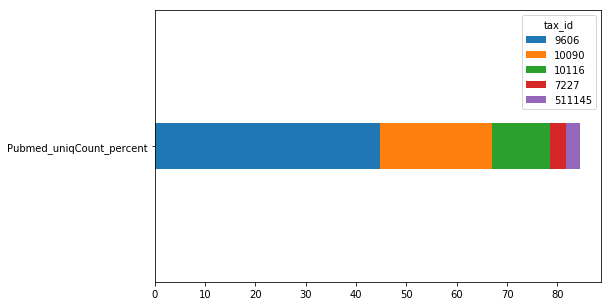

In [160]:
#totalpubmeduniqCountspp.head()
totalpubmeduniqCountspp_per = totalpubmeduniqCountspp[['tax_id','Pubmed_uniqCount_percent']]
test = totalpubmeduniqCountspp_per.head().set_index('tax_id').T
test.head()
plt.figure(figsize=(20,20))
test.head().plot.barh(stacked=True, width = 0.1,figsize = (8,5))

In [8]:
gene2pubmed.shape

(10695821, 3)